In [1]:
# import enviorments
import tensorflow as tf

In [2]:
tf.__version__

'1.4.1'

# Gathering data

# Content
- Data
> There are 15 participants and corresponding folder from p00 to p14. Each folder includes the images inside the different day folder.

- Annotation
> There are pxx.txt file in each participant folder. which saves the information:

Dimension 1: image file path and name.

Dimension 2~3: Gaze location on the screen coordinate in pixels, the actual screen size can be found in the "Calibration" folder.

Dimension 4~15: (x,y) position for the six facial landmarks, which are four eye corners and two mouth corners.

Dimension 16~21: The estimated 3D head pose in the camera coordinate system based on 6 points-based 3D face model, rotation and translation: we implement the same 6 points-based 3D face model in [1], which includes the four eye corners and two mouth corners

Dimension 22~24 (fc): Face center in the camera coordinate system, which is averaged 3D location of the 6 focal landmarks face model. Not it is slightly different with the head translation due to the different centers of head and face.

Dimension 25~27 (gt): The 3D gaze target location in the camera coordinate system. The gaze direction can be calculated as gt - fc. 

Dimension 28: Which eye (left or right) is used for the evaluation subset in [2].

- Calibration
> There is the "Calibration" folder for each participant, which contains

(1)Camera.mat: the intrinsic parameter of the laptop camera. "cameraMatrix": the projection matrix of the camera. "distCoeffs": camera distortion coefficients. "retval": root mean square (RMS) re-projection error. "rvecs": the rotation vectors. "tvecs": the translation vectors.

(2) monitorPose.mat: the position of image plane in camera coordinate. "rvecs": the rotation vectors. "tvecs": the translation vectors.

(3) creenSize.mat: the laptop screen size. "height_pixel": the screen height in pixel. "width_pixel": the screen width in pixel. "height_mm": the screen height in millimeter. "width_mm": the screen width in millimeter.

In [3]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=2


# Data preprocessing
1. Read the lable data for each image.
2. Find the explaination of annotation.txt.

In [4]:
# Read annotation.txt of data/origin/p00/day01
import pandas as pd

1. This is no null value in the table.
## Data assessing

## Define
1. Draw the pixels of one annotation in matplotlib with pyplot
2. filter contour to original images.

## Code

In [6]:
from matplotlib import pyplot as plt

In [12]:
import numpy as np

In [ ]:
plt.plot(contour_points)

In [ ]:
import numpy as np

In [ ]:
x = np.reshape(contour_points, [12, 2])[:, 0]

In [8]:
y = np.reshape(contour_points, [12, 2])[:, 1]

NameError: name 'np' is not defined

In [9]:
plt.plot(x ,y, 'o')

NameError: name 'x' is not defined

In [ ]:
fig = plt.figure(figsize=(20, 30))
implot = plt.imshow(p00_image)
plt.plot(x, y, '.', )
plt.show()

In [ ]:
from scipy import io

In [ ]:
p00_d1 = io.loadmat('/nfshome/xueqin/deeplearning/gaze_estimation/data/MPIIGaze/Data/Normalized/p00/day01.mat')

In [ ]:
p00_d1.keys()

In [ ]:
p00_d1['data'][0][0][0][0][0][0].shape

## define
1. Find out the data structure of mat file.

In [ ]:
import numpy as np

In [ ]:
# check shape of each layer in the p00_d1
def check_shape(file):
    return print(np.shape(file))

In [ ]:
check_shape(p00_d1)

In [ ]:
check_shape(p00_d1['data'])

In [ ]:
check_shape(p00_d1['data'][0])

In [ ]:
check_shape(p00_d1['data'][0][0])

In [ ]:
check_shape(p00_d1['data'][0][0][0])

In [ ]:
check_shape(p00_d1['data'][0][0][0][0])

In [ ]:
check_shape(p00_d1['data'][0][0][0][0][0])

In [ ]:
check_shape(p00_d1['data'][0][0][0][0][0][0])

- The data is in 5 depth of the data set.

## define
draw the direction on image.

In [ ]:
from glob import glob
pathname = '/nfshome/xueqin/deeplearning/gaze_estimation/data/MPIIGaze/Data/Original/p00/day01/'
import os
ori_im_dr = glob((os.path.join(pathname, '*.jpg'))) # original images derectories p00 day01.
# TODO return image path based on person and day and number.
def image_path(number):
    '''Return image path from number p00 day01
    Parameter: image number(int)
    return: path (str)'''
    
    pathname = '/nfshome/xueqin/deeplearning/gaze_estimation/data/MPIIGaze/Data/Original/p00/day01/'
    return glob((os.path.join(pathname, str(number)+'.jpg')))
image_path('001')

In [ ]:
# every line in the data is one direction of one image.
# make the image as the background and then draw 3d direction on the background.
# pick normalized data p00's first direction and first image.
directions_p00 = p00_d1['data'][0][0][0][0][0][0] # 3D directions array of 995 images in p00, day01, shape (995, 3)

normalized_images = skimage.io.imread(ori_im_dr[0])

In [ ]:
skimage.io.imshow(normalized_images)

## Define
1. Draw the direction in annotation.mat on corresponding original image.
    - Whether the annotation includes file address.
    - skiimage API to draw 3D derection and on specific background.

In [ ]:
# check whether the path is in the annotation.txt
p00_d1.keys() # keys in one annotation file.

In [ ]:
p00_d1['__header__']

In [ ]:
p00_d1['__version__']

In [ ]:
p00_d1['__globals__']

In [ ]:
len(p00_d1['filenames']) # file name is in the filenames key.

1. The file name is including in the annotation file.

## Define 
1. key 'data' coorresponding to filename.

In [ ]:
# recursive function to extract data 
def recursive_check(data):
    if data is not None:
        if type(data) is np.ndarray:
            # print('type:',type(data))
            print(np.shape(data))
            recursive_check(data[0])
        elif type(data) is np.void:
            print(type(data))
            recursive_check(data[0])
        return 'done'
    return

In [ ]:
recursive_check(p00_d1['data'])

In [ ]:
p00_d1['data'][0][0][0][0][0]

In [ ]:
np.shape(p00_d1['data'][0][0][0][0][0][0]) # direction or not?

In [ ]:
np.shape(p00_d1['data'][0][0][0][0][0][1]) # image

In [ ]:
np.shape(p00_d1['data'][0][0][0][0][0][2]) # 

In [ ]:
skimage.io.imshow(p00_d1['data'][0][0][0][0][0][1][0])

# Another dataset "It's all written on your face"

## Data gathering

[It's written all over your face data_url](https://www.mpi-inf.mpg.de/departments/computer-vision-and-multimodal-computing/research/gaze-based-human-computer-interaction/its-written-all-over-your-face-full-face-appearance-based-gaze-estimation/)

[original dataset](http://datasets.d2.mpi-inf.mpg.de/MPIIGaze/MPIIFaceGaze.zip)

[normalized dataset](http://datasets.d2.mpi-inf.mpg.de/MPIIGaze/MPIIFaceGaze_normalized.zip)

### Define
1. Difference between original dataset and normalized data set.
2. Original image whether is full face or not.
3. Calculate direction for every image.

In [ ]:
# Difference between original and normalized data set.
# original data set derectory
original_dr = '/nfshome/xueqin/deeplearning/gaze_estimation/data/all_writte/MPIIFaceGaze/'
# data is in the p00/dayxx/xxx.jpg
# define a function with parameter person, day, and number of image.
def showIm2Nd(person, day, number, dr=original_dr):
    original_dr = '/nfshome/xueqin/deeplearning/gaze_estimation/data/all_writte/MPIIFaceGaze/'
    selectedIm = original_dr+'p{:02}/day{:02}/{:04}.jpg'.format(person, day, number)
    return selectedIm

In [ ]:
showIm2Nd(1, 2, 3)

In [ ]:
# test showIm2Nd
skimage.io.imshow(showIm2Nd(1,31,188))

In [ ]:
# Calculate direction for every iamge.
# Annotation file and its meaning.
# Equation to calculate with Annotation file.
# Annotation file address
def annotationDr(person):
    'return annotation file for specific person.'
    original_dr = '/nfshome/xueqin/deeplearning/gaze_estimation/data/all_writte/MPIIFaceGaze/'
    return original_dr + 'p{:02}/p{:02}.txt'.format(person, person)

In [ ]:
# test annotation directory function
annotationDr(1)

In [ ]:
# Read annotation file.
def annotation_file_reader(file_address):
    '''
    Read annotation file and return right format as indicted in the paper.
    '''
    return pd.read_csv(file_address, delim_whitespace=True, names=[i for i in range(1, 29)], index_col=False)

In [ ]:
annotationDr(1)

In [ ]:
annotation_file_reader(annotationDr(1)).values[0]

In [ ]:
# test annotation file reader.
annotation_file_reader(annotationDr(1))

1. The images in each person and files are not in sequensal.
2. What is the evaluation dataset used for.

### calculate every direction of the images

Dimension 1: image file path and name.

Dimension 2~3: Gaze location on the screen coordinate in pixels, the actual screen size can be found in the "Calibration" folder.

Dimension 4~15: (x,y) position for the six facial landmarks, which are four eye corners and two mouth corners.

Dimension 16~21: The estimated 3D head pose in the camera coordinate system based on 6 points-based 3D face model, rotation and translation: we implement the same 6 points-based 3D face model in [1], which includes the four eye corners and two mouth corners

Dimension 22~24 (fc): Face center in the camera coordinate system, which is averaged 3D location of the 6 focal landmarks face model. Not it is slightly different with the head translation due to the different centers of head and face.

Dimension 25~27 (gt): The 3D gaze target location in the camera coordinate system. The gaze direction can be calculated as gt - fc. 

Dimension 28: Which eye (left or right) is used for the evaluation subset in [2].

In [ ]:
# calculate every direction of the images.
annotation_origin = annotation_file_reader(annotationDr(2)) # read the person 2's annotation file.

In [ ]:
# copy annotation origin
annotation_clean = annotation_origin.copy()

In [ ]:
# Face center
face_center = annotation_clean.iloc[:, 22:25]

In [ ]:
# test face center
face_center.describe()

In [ ]:
# gaze target
gt = annotation_clean.iloc[:, 24:27]

In [ ]:
# test target
gt.describe()

In [ ]:
# calculate gaze direction
gaze_direction = gt.values - face_center.values

In [ ]:
gaze_direction

### Draw direction in 3D

In [ ]:
# Use data from images to show image and direction
# one directory of annotation.
def show_image_direction(annotation_dr):
    fig = plt.figure()
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    x, y, z = gaze_cal(annotation_dr)
    plt.plot([x,0],[y, 0],[z, 0], label='gaze_direction')
    plt.subplot(122)
    plt.imshow(plt.imread())

In [ ]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(14, 16))
ax = fig.add_subplot(1, 2, 1, projection='3d')

# theta = np.linspace(-4 * np.pi, 4 * np.pi, 100)
#z = np.linspace(-2, 2, 100)
#r = z**2 + 1
#x = r * np.sin(theta)
#y = r * np.cos(theta)
x = gaze_direction[0][0]
y = gaze_direction[0][1]
z = gaze_direction[0][2]
plt.plot([x,0],[y, 0],[z, 0], label='parametric curve')
# plt.plot([0,1],[0,1],[0,1])
# ax.legend(
#ax.set_zlim3d(-100, 100)

plt.subplot(122)
plt.imshow(plt.imread(showIm2Nd(1, 1, 5)))
plt.show()

In [ ]:
import matplotlib.pyplot as plt
# plot a line, implicitly creating a subplot(111)
plt.plot([1,2,3])
# now create a subplot which represents the top plot of a grid
# with 2 rows and 1 column. Since this subplot will overlap the
# first, the plot (and its axes) previously created, will be removed
plt.subplot(211)
plt.plot(range(12))
plt.subplot(212, facecolor='y') # creates 2nd subplot with yellow background

In [ ]:
gaze_direction.shape

In [ ]:
# gaze calculator
def gaze_cal(annotation_file):
    '''
    return gaze direction of three dimension vector
    Parameter
    ---------
    annotation_file: DataFrame annotation file.
    Return
    ------
    Numpy array of shape (m, x, y, z)
    '''
    return annotation_file.iloc[:, 24:27].values - annotation_file.iloc[:, 22:25].values

In [ ]:
# test gaze cal
gaze_cal(annotation_file_reader(annotationDr(1))).shape

## Define
1. Combine gaze estimation in the original table.
    - Append to the next three columns.
2. Draw direction on the image.
    1. Whether do I need a fixed center point.

In [ ]:
gaze_direction = gaze_cal(annotation_file_reader(annotationDr(1))) # gaze direction of person 1.
skimage.draw.line_aa(1, 1, 8, 8)

In [ ]:
rr, cc, val = skimage.draw.line_aa(0,0,8,8)
img = np.zeros((10, 10))
img[rr, cc] = val * 255

In [ ]:
skimage.io.imshow(showIm2Nd(1,1,5))

## Try to use Opencv to project 3D direction on 2D image.

In [ ]:
# all the jpg file address in the folder
showIm2Nd(1, 1, 1)

In [ ]:
import numpy as np
import cv2
import glob

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

In [ ]:
objp = np.zeros((6*7,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:6].T.reshape(-1,2)

In [ ]:
%matplotlib inline

In [ ]:
plt.imshow(objp)

In [ ]:
pathname = '/nfshome/xueqin/deeplearning/opencv_sample/data/'
images = glob.glob(pathname+'right*.jpg')

In [ ]:
images

In [ ]:
np.mgrid[0:7, 0:6].T.reshape(-1,2).shape

In [ ]:
objp.shape

In [ ]:
import numpy as np
import cv2
import glob

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*7,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

pathname = '/nfshome/xueqin/deeplearning/opencv_sample/data/'
images = glob.glob(pathname+'right*.jpg')

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (7,6),None)
    #print(ret)
    #print(corners.shape)
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)

        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        print(corners2.shape)
        imgpoints.append(corners2)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (7,6), corners2,ret)
        plt.imshow(img)
#        cv2.imshow('img',img)
#        cv2.waitKey(500)

cv2.destroyAllWindows()

The above is the code to decrease the distortion of camera.

Distortion is the camera inside error which will take effect on the edge.

In [ ]:
# Draw function to draw 3D coordinate system on plane image.
def draw(img, corners, imgpts):
    corner = tuple(corners[0].ravel())
    img = cv2.line(img, corner, tuple(imgpts[0].ravel()), (255,0,0), 5)
    img = cv2.line(img, corner, tuple(imgpts[1].ravel()), (0,255,0), 5)
    img = cv2.line(img, corner, tuple(imgpts[2].ravel()), (0,0,255), 5)
    return img

In [ ]:
CAMERAMATRIX =io.loadmat('/nfshome/xueqin/deeplearning/gaze_estimation/data/all_writte/MPIIFaceGaze/p01/Calibration/Camera.mat')

In [ ]:
CAMERAMATRIX.keys()

In [ ]:
annotationDr(0)

In [ ]:
annotation_file_reader(annotationDr(0))

In [ ]:
import scipy

In [ ]:
MPIIFaceGaze_address = '/nfshome/xueqin/deeplearning/gaze_estimation/data/all_writte/MPIIFaceGaze/'

In [ ]:
import glob 
def get_Calibration(person):
    "Return three calibration xxx.mat address."
    calibration_files = glob.glob(MPIIFaceGaze_address+'p{:02}/Calibration/*.mat'.format(person))
    # print(calibration_files)
    return calibration_files

In [ ]:
get_Calibration(1)

In [ ]:
scipy.io.loadmat(get_Calibration(1)[0]).keys()

In [ ]:
# Read Camera matrix mat file.
def read_camara_mx(file_path):
    '''
    return mtx, dist from camera mx
    
    Parameter
    ---------
    get_calibration(person)[0]
    '''
    mx = scipy.io.loadmat(file_path)
    cameraMatrix = mx['cameraMatrix']
    distCoeffs = mx['distCoeffs']
    retval = mx['retval']
    rvecs = mx['rvecs'] # rotation vector
    tvecs = mx['tvecs'] # translation vector
    return cameraMatrix, distCoeffs, rvecs, tvecs

In [ ]:
mtx, dist, _, _ = read_camara_mx(get_Calibration(0)[0])

In [ ]:
import cv2

In [ ]:
import cv2
import numpy as np
import glob
import scipy
# Load previously saved data
# with np.load('B.npz') as X:
#    mtx, dist, _, _ = [X[i] for i in ('mtx','dist','rvecs','tvecs')]
def draw(img, corners, imgpts):
    corner = tuple(corners[0].ravel())
    img = cv2.line(img, corner, tuple(imgpts[0].ravel()), (255,0,0), 5)
    img = cv2.line(img, corner, tuple(imgpts[1].ravel()), (0,255,0), 5)
    img = cv2.line(img, corner, tuple(imgpts[2].ravel()), (0,0,255), 5)
    return img
# corners is the landmarks
landmarks = annotation_file_reader(annotationDr(0)).iloc[:, 3:15]

def draw(img, corners, imgpts):
    corner = tuple(corners[0].ravel())
    img = cv2.line(img, corner, tuple(imgpts[0].ravel()), (255,0,0), 5)
    img = cv2.line(img, corner, tuple(imgpts[1].ravel()), (0,255,0), 5)
    img = cv2.line(img, corner, tuple(imgpts[2].ravel()), (0,0,255), 5)
    return img

axis = np.float32([[3,0,0], [0,3,0], [0,0,-3]]).reshape(-1,3)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

### Project 3D line to 2D image.
- Use project_points
- Parameter
    - tranlation matrix
    - rotation matrix
    - camera matrix
    - distortion matrix
    - line parralle to Z axis.

In [46]:
import cv2
from matplotlib import pyplot as plt
import skimage
import scipy
from scipy.io import loadmat
import numpy as np
import pandas as pd
import glob

def normalize(poinrts):
    for row in points:
        row /= points[-1]
    return points

def make_homog(points):
    return np.vstack((points, ones((1, points.shape[1]))))

def annotationDr(person):
    'return annotation file for specific person.'
    original_dr = '/nfshome/xueqin/deeplearning/gaze_estimation/data/all_writte/MPIIFaceGaze/'
    return original_dr + 'p{:02}/p{:02}.txt'.format(person, person)

def annotation_file_reader(file_address):
    '''
    Read annotation file and return right format as indicted in the paper.
    '''
    return pd.read_csv(file_address, delim_whitespace=True, names=[i for i in range(1, 29)], index_col=False)

def get_Calibration(person):
    "Return three calibration xxx.mat address."
    calibration_files = glob.glob(MPIIFaceGaze_address+'p{:02}/Calibration/*.mat'.format(person))
    # print(calibration_files)
    return calibration_files

# Read Camera matrix mat file.
def read_camara_mx(file_path):
    '''
    return mtx, dist from camera mx
    
    Parameter
    ---------
    get_calibration(person)[0]
    '''
    mx = scipy.io.loadmat(file_path)
    cameraMatrix = mx['cameraMatrix']
    distCoeffs = mx['distCoeffs']
    retval = mx['retval']
    rvecs = mx['rvecs'] # rotation vector
    tvecs = mx['tvecs'] # translation vector
    return cameraMatrix, distCoeffs, rvecs, tvecs

# gaze calculator
def gaze_cal(annotation_file):
    '''
    return gaze direction of three dimension vector
    Parameter
    ---------
    annotation_file: DataFrame annotation file.
    Return
    ------
    Numpy array of shape (m, x, y, z)
    '''
    return annotation_file.iloc[:, 24:27].values - annotation_file.iloc[:, 22:25].values

In [15]:
# use cv2.projectPoints
# Find the parameters first.
# test image
annotationDr(1)

'/nfshome/xueqin/deeplearning/gaze_estimation/data/all_writte/MPIIFaceGaze/p01/p01.txt'

In [16]:
t_annotation_dataframe = annotation_file_reader(annotationDr(1)) # test annotation dataframe of person 1.

In [17]:
CAMERAMATRIX = loadmat('/nfshome/xueqin/deeplearning/gaze_estimation/data/all_writte/MPIIFaceGaze/p01/Calibration/Camera.mat')

In [18]:
t_cameraMatrix = CAMERAMATRIX['cameraMatrix']

In [19]:
t_translation = CAMERAMATRIX['tvecs']

In [20]:
t_translation.shape

(100, 3)

In [21]:
t_rotation = CAMERAMATRIX['rvecs']

In [22]:
t_rotation.shape

(100, 3)

In [23]:
t_dist = CAMERAMATRIX['distCoeffs']

In [24]:
t_dist.shape

(1, 5)

In [25]:
t_direction = gaze_cal(t_annotation_dataframe) # m X 3D

In [26]:
t_direction[0]

array([-114.531068, -430.817835,  102.62548 ])

In [27]:
t_start_point = t_annotation_dataframe.iloc[:,1:3] # start points to draw line.

In [28]:
t_start_point_tuple = tuple(t_start_point.iloc[0, :].values)

In [29]:
t_end_point, _ = cv2.projectPoints(np.array([(0.0, 0.0, 1000.0)]), t_rotation[0], t_translation[0], t_cameraMatrix, t_dist)

In [30]:
t_end_point = (t_end_point[0][0][0], t_end_point[0][0][1])

In [31]:
t_end_point

(-203.37294348337718, 237.3704554410287)

In [32]:
# Get file address from annotation file.
t_annotation_dataframe[1][0]

'day01/0005.jpg'

In [34]:
t_test = cv2.imread('/nfshome/xueqin/deeplearning/gaze_estimation/data/all_writte/MPIIFaceGaze/p01/day01/0005.jpg')

In [35]:
# convert to normal image
t_test = cv2.cvtColor(t_test, cv2.COLOR_BGR2RGB)

In [36]:
img = cv2.line(t_test, t_start_point_tuple, (-203, 237), (255,0,0), 2)

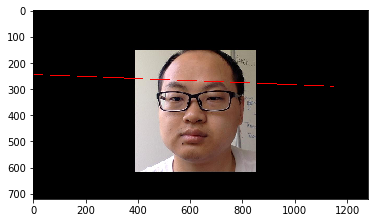

In [37]:
plt.imshow(img)

### Define
1. check the file is the same or not.
2. change the start point to draw, different landmarks.

### use annotation dataframe to extract the direction and projected it on the image.

In [38]:
def read_image(file_address):
    '''
    Return RGB array format.
    '''
    return cv2.cvtColor(cv2.imread(file_address), cv2.COLOR_BGR2RGB)

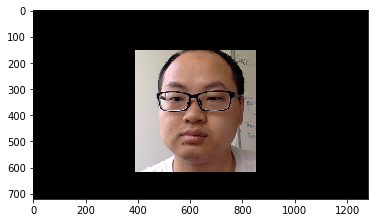

In [39]:
plt.imshow(read_image('/nfshome/xueqin/deeplearning/gaze_estimation/data/all_writte/MPIIFaceGaze/p01/day01/0005.jpg'))

In [41]:
MPIIFaceGaze_address = '/nfshome/xueqin/deeplearning/gaze_estimation/data/all_writte/MPIIFaceGaze/'

In [149]:
person = 3

In [150]:
get_Calibration(person)

['/nfshome/xueqin/deeplearning/gaze_estimation/data/all_writte/MPIIFaceGaze/p03/Calibration/Camera.mat',
 '/nfshome/xueqin/deeplearning/gaze_estimation/data/all_writte/MPIIFaceGaze/p03/Calibration/monitorPose.mat',
 '/nfshome/xueqin/deeplearning/gaze_estimation/data/all_writte/MPIIFaceGaze/p03/Calibration/screenSize.mat']

In [151]:
mx, dis, rc, tv = read_camara_mx(get_Calibration(person)[0])

In [152]:
r = loadmat(get_Calibration(person)[1])['rvects']
t = loadmat(get_Calibration(person)[1])['tvecs']

In [153]:
# TODO: project 3D estimated pose 

In [154]:
t_end_point, _ = cv2.projectPoints(np.array([(0.0, 0.0, 1000.0)]), r, t, t_cameraMatrix, t_dist)

In [155]:
t_end_point

array([[[456.29578628, 226.51308719]]])

In [156]:
img = cv2.line(t_test, (531, 336), (543, 232), (255,0,0), 2)

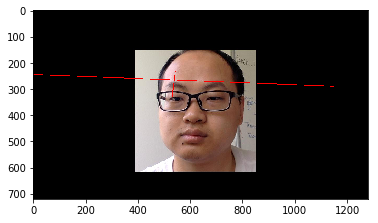

In [157]:
plt.imshow(img)

# Try the different pipeline

In [158]:
# not all the files are included in the annotation.txt file.
# The draw task should be used to related the annotation file.
# So that all the parameters should be used according to the annotation file.
# open once, extract
# file address
# Camera matrix. rotation, translation, distortion
# landmarks
# Gaze location
# estimated head pose (what is this)
# face center
# gaze target
# left or right
def parameter_extracter(annotation_df, person):
    root_directory = '/nfshome/xueqin/deeplearning/gaze_estimation/data/all_writte/MPIIFaceGaze/p{:02}/'.format(person)
    file_address = root_directory + annotation_df[1]
    gaze_location = annotation_df.iloc[:, 1:3].values
    landmarks = annotation_df.iloc[:, 3:15].values
    estimated_head_pose = annotation_df.iloc[:, 15:21].values
    face_center = annotation_df.iloc[:, 21:24].values
    gaze_target = annotation_df.iloc[:, 24:27].values
    return file_address, gaze_location, landmarks, estimated_head_pose, face_center, gaze_target

In [320]:
person = 10

In [321]:
annotation_dataframe = annotation_file_reader(annotationDr(person))

In [322]:
parameters = parameter_extracter(annotation_dataframe,person)

In [323]:
parameters[0][0]

'/nfshome/xueqin/deeplearning/gaze_estimation/data/all_writte/MPIIFaceGaze/p10/day01/0001.jpg'

In [324]:
im = cv2.imread(parameters[0][0])

In [325]:
size = im.shape

In [326]:
size

(720, 1280, 3)

In [327]:
image_points = parameters[2][0].reshape((6,2))

In [328]:
parameters[3]# estimated head pose

array([[-8.41500000e-02, -3.39120000e-02, -1.82180000e-02,
         1.49558950e+01, -1.07719480e+01,  4.38342653e+02],
       [-9.34730000e-02,  2.84400000e-03, -2.01940000e-02,
         1.39455640e+01, -8.86807500e+00,  4.38055651e+02],
       [-1.31379000e-01,  5.56000000e-04, -2.33180000e-02,
         1.17575740e+01, -4.97387700e+00,  4.46695977e+02],
       ...,
       [ 1.16795000e-01,  4.56470000e-01, -1.04260000e-02,
         2.53218610e+01, -5.39919810e+01,  3.81072058e+02],
       [ 1.04615000e-01,  2.11943000e-01, -1.39380000e-02,
         4.38648600e+00, -5.42946900e+01,  3.99998031e+02],
       [ 8.91480000e-02,  4.66279000e-01,  1.17760000e-02,
         3.47916630e+01, -4.69903490e+01,  3.84789816e+02]])

In [329]:
parameters[3].shape

(2194, 6)

In [330]:
# Head pose is the 6 * 1 metrix, is it another coordinate?
# It seems to be the Euler angels
# TODO: Change Euler Angles into rotation matrix.
# TODO: Use the face model as the model point
face_model_points = '/nfshome/xueqin/deeplearning/gaze_estimation/data/MPIIGaze/Data/6 points-based face model.mat'
model_points = loadmat(face_model_points)['model'].reshape((6,3))

In [331]:
model_points

array([[-4.50967681e+01, -2.13128582e+01,  2.13128582e+01],
       [ 4.50967681e+01, -2.62995769e+01,  2.62995769e+01],
       [-4.83773045e-01,  4.83773045e-01,  4.83773045e-01],
       [-4.83773045e-01,  6.85950353e+01,  6.85950353e+01],
       [ 2.39702984e+00, -2.39702984e+00, -2.39702984e+00],
       [ 2.39702984e+00, -9.86076132e-32, -9.86076132e-32]])

In [332]:
# camrta internals
t_cameraMatrix

array([[1.05231533e+03, 0.00000000e+00, 6.28194836e+02],
       [0.00000000e+00, 1.05220563e+03, 3.54482374e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [333]:
t_dist

array([[ 1.20709897e-01, -4.62686975e-01, -5.24296062e-05,
        -1.37636102e-03,  4.57557296e-01]])

In [334]:
t_rotation[0]

array([ 0.07471399, -0.7522198 , -0.12311554])

In [335]:
t_translation[0]

array([-245.60580609, -107.66814825,  461.2703076 ])

In [336]:
(parameters[4][0])

array([ 15.404468,  12.008375, 436.428376])

In [337]:
landmarks = parameters[2][0]

In [338]:
tuple(map(int, (1.2, 455.45)))

(1, 455)

In [339]:
image = plt.imread(parameters[0][0])

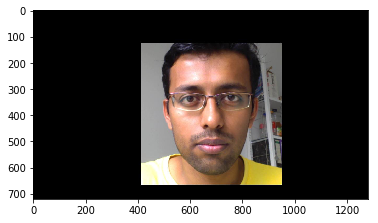

In [340]:
plt.imshow(image)

In [341]:
parameters[2][0]

array([573, 341, 632, 342, 730, 339, 788, 337, 620, 510, 748, 507])

In [342]:
landmarks = parameters[2][0]

In [343]:
landmarks.reshape(-1, 2)[0]

array([573, 341])

In [344]:
parameters[4][0] - parameters[5][0]

array([  8.44768 ,   5.321527, 428.452494])

In [345]:
# locate landmarks on image
# plt.imshow(cv2.line(image, (531, 336), (575, 339), (255, 0, 0), 2))

In [346]:
# draw projection function
def draw_gaze(image, start, face_center, gaze_target, camera_matrix, diss, rotation, translation):
    gaze_direction = gaze_target - face_center
    gaze_direction = gaze_direction.reshape(-1, 3)
    end_point, _ = cv2.projectPoints(gaze_direction, rotation, translation, camera_matrix, diss)
#    print(end_point[0][0])
    cv2.line(image, tuple(start), tuple(map(int, (end_point[0][0]))), (255, 0, 0), 2)
    return image

#### Test code

In [347]:
np.array([(0.0,0.0,100.0)]).shape

(1, 3)

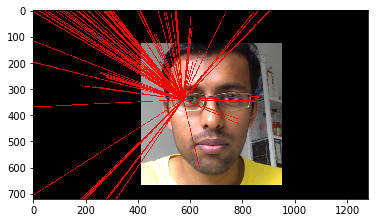

In [365]:
for i in range(1,100):
    plt.imshow(draw_gaze(image, landmarks.reshape(-1, 2)[0], parameters[4][0], parameters[5][0], t_cameraMatrix, t_dist, t_rotation[i], t_translation[i]))

In [364]:
test_image = draw_gaze(image, landmarks.reshape(-1, 2)[0], parameters[4][0], parameters[5][0], t_cameraMatrix, t_dist, t_rotation[9], t_translation[9])

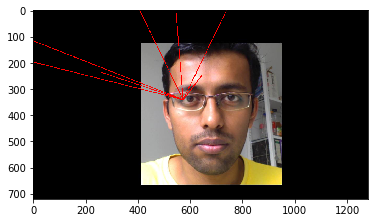

In [363]:
plt.imshow(test_image)

In [189]:
# Use t, R from an other file
rvects = loadmat(get_Calibration(person)[1])['rvects']

In [190]:
tvecs = loadmat(get_Calibration(person)[1])['tvecs']

In [191]:
test_image = draw_gaze(image, landmarks.reshape(-1, 2)[0], parameters[4][0], parameters[5][0], t_cameraMatrix, t_dist, rvects, tvecs)

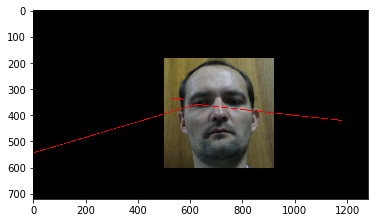

In [192]:
plt.imshow(test_image)

In [193]:
loadmat(get_Calibration(person)[0]).keys()

dict_keys(['rvecs', '__globals__', 'tvecs', '__version__', '__header__', 'distCoeffs', 'retval', 'cameraMatrix'])

In [194]:
tvecs = loadmat(get_Calibration(person)[0])['tvecs']

In [195]:
rvecs = loadmat(get_Calibration(person)[0])['rvecs']

### define
1. draw_image(person)-->image:ndarray
2. save image

In [376]:
def draw_image(person):
    annotation_dataframe = annotation_file_reader(annotationDr(person))
    parameters = parameter_extracter(annotation_dataframe,person)
    im = plt.imread(parameters[0][0])
    image_points = parameters[2][0].reshape((6,2))
    landmarks = parameters[2][0]
    test_image = draw_gaze(im, landmarks.reshape(-1, 2)[0], 
                           parameters[4][0], parameters[5][0], 
                           t_cameraMatrix, t_dist, t_rotation[9], t_translation[9])
    return test_image

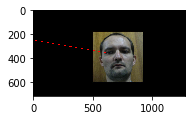

In [400]:
person = 0
for x in range(1,3):
    for y in range(1,3):
        plt.subplot(x, y, 1)
        plt.imshow(draw_image(person))
        person += 1

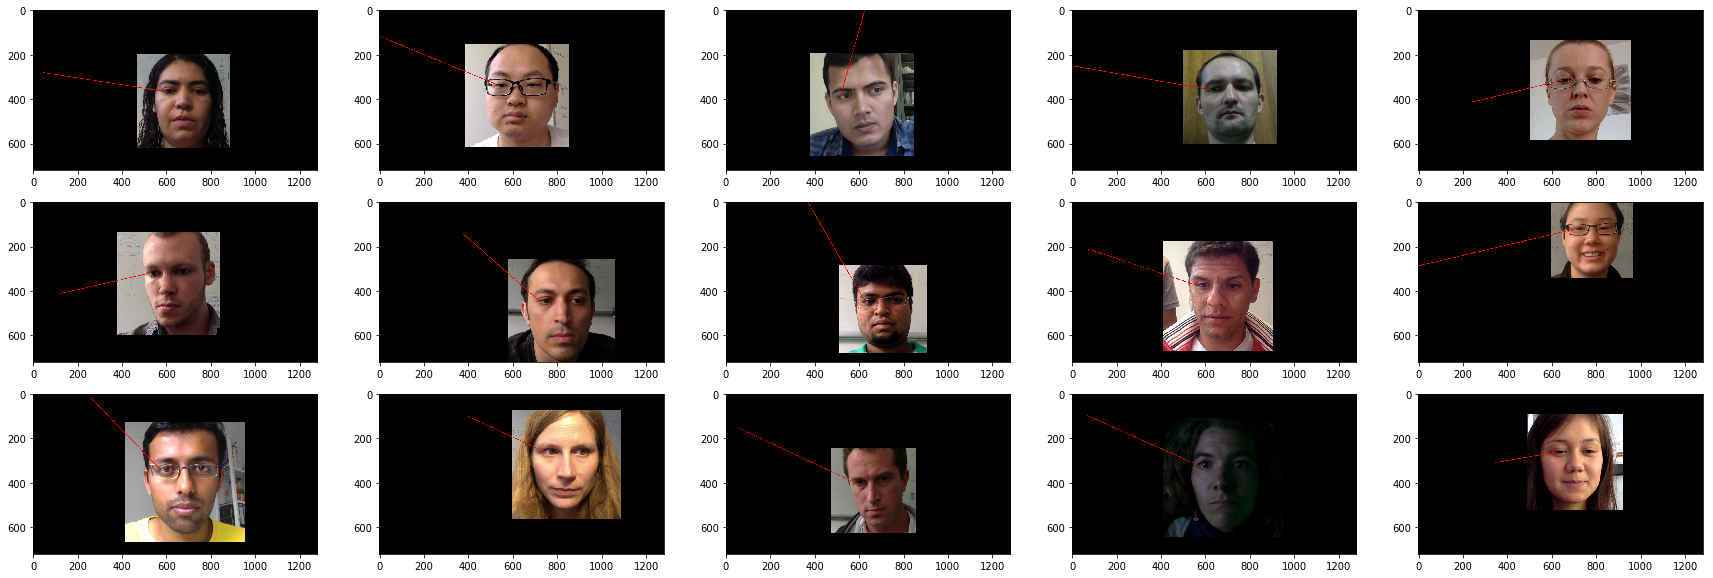

In [413]:
plt.figure(1,(30,10))
for person in range(1, 16):
    plt.subplot(3, 5, person)
    plt.imshow(draw_image(person-1))

In [415]:
for i in [0, 4, 5,9]:
    plt.imsave('/nfshome/xueqin/deeplearning/gaze_estimation/{}'.format(i), draw_image(i))